In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
import inspect
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from qlstm_pennylane import QLSTM



# preprocessing

In [2]:
df_half_hour=pd.read_csv('daily_max_temp_SDL.csv')
df_half_hour.isna().sum()

dwpf      0
relh      0
drct      0
sknt      0
alti      0
mslp      0
vsby      0
temp_c    0
dtype: int64

In [3]:
daily_max_temp=df_half_hour
daily_max_temp

,dwpf,relh,drct,sknt,alti,mslp,vsby,temp_c
0,14.0,12.74,184.994451,3.0,30.14,1019.7,10.0,19.444444
1,26.0,19.77,310.000000,5.0,30.03,1015.7,10.0,20.555556
2,23.0,16.26,0.000000,0.0,30.07,1017.3,10.0,21.666667
3,21.0,14.51,120.000000,6.0,30.07,1017.2,10.0,22.222222
4,25.0,17.67,240.000000,4.0,30.05,1016.3,10.0,21.666667
...,...,...,...,...,...,...,...,...
5402,39.0,14.78,180.000000,7.0,29.81,1006.8,10.0,34.444444
5403,38.0,16.10,270.000000,6.0,29.78,1006.2,10.0,32.222222
5404,47.0,28.45,250.000000,3.0,29.71,1003.7,10.0,28.333333
5405,37.0,30.84,140.000000,4.0,30.06,1016.3,10.0,20.555556


In [4]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 41.11111111111112


,dwpf,relh,drct,sknt,alti,mslp,vsby,temp_c
0,14.0,12.74,184.994451,3.0,30.14,1019.7,10.0,19.444444
1,26.0,19.77,310.000000,5.0,30.03,1015.7,10.0,20.555556
2,23.0,16.26,0.000000,0.0,30.07,1017.3,10.0,21.666667
3,21.0,14.51,120.000000,6.0,30.07,1017.2,10.0,22.222222
4,25.0,17.67,240.000000,4.0,30.05,1016.3,10.0,21.666667
...,...,...,...,...,...,...,...,...
5402,39.0,14.78,180.000000,7.0,29.81,1006.8,10.0,34.444444
5403,38.0,16.10,270.000000,6.0,29.78,1006.2,10.0,32.222222
5404,47.0,28.45,250.000000,3.0,29.71,1003.7,10.0,28.333333
5405,37.0,30.84,140.000000,4.0,30.06,1016.3,10.0,20.555556


# some functions needed

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Normalize data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Build and compile LSTM model
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(input_shape[-1]))  # Output neurons equal to feature count
    
    # Create the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model

# Function to plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()

def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    model.eval()  # Set model to evaluation mode
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []

        for i in range(n_samples - step + 1):
            sequence = x_test[i]  # Shape: (seq_len, n_features)

            # Perform recursive prediction for t in [0, step-1)
            for t in range(step - 1):
                input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)  # Add batch dimension
                with torch.no_grad():
                    prediction = model(input_tensor)
                prediction = prediction.numpy().reshape(1, n_features)
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for current step
            input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)
            with torch.no_grad():
                final_prediction = model(input_tensor)

            final_prediction_np = final_prediction.numpy()
            predictions.append(final_prediction_np[0])  # shape: (n_features,)

        # Inverse transform and reshape
        predictions = scaler.inverse_transform(np.array(predictions))
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict





# seq 7 predict 3 temp_c

In [18]:
import torch
import torch.nn as nn
import pennylane as qml

class QLSTM_7_3(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 n_qubits=4,
                 n_qlayers=1,
                 batch_first=True,
                 return_sequences=False,
                 return_state=False,
                 backend="default.qubit"):
        super(QLSTM_7_3, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        # Define wire names for devices
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        # Define quantum circuits with IQPEmbedding
        def _circuit_forget(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_forget, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]

        def _circuit_input(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_input, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]

        def _circuit_update(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_update, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]

        def _circuit_output(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_output, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]

        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        if self.batch_first:
            batch_size, seq_length, _ = x.size()
        else:
            seq_length, batch_size, _ = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)
            c_t = torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t)))

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0).transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)



Number of sequences: 5398
X_train_7_3 shape: (4318, 7, 1), X_test_7_3 shape: (1080, 7, 1)
y_train_7_3 shape: (4318, 3, 1), y_test_7_3 shape: (1080, 3, 1)
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 3)
Epoch 10/300, Loss: 0.2300
Epoch 20/300, Loss: 0.0705
Epoch 30/300, Loss: 0.0507
Epoch 40/300, Loss: 0.0418
Epoch 50/300, Loss: 0.0419
Epoch 60/300, Loss: 0.0393
Epoch 70/300, Loss: 0.0348
Epoch 80/300, Loss: 0.0258
Epoch 90/300, Loss: 0.0152
Epoch 100/300, Loss: 0.0092
Epoch 110/300, Loss: 0.0089
Epoch 120/300, Loss: 0.0076
Epoch 130/300, Loss: 0.0074
Epoch 140/300, Loss: 0.0070
Epoch 150/300, Loss: 0.0069
Epoch 160/300, Loss: 0.0068
Epoch 170/300, Loss: 0.0067
Epoch 180/300, Loss: 0.0066
Epoch 190/300, Loss: 0.0065
Epoch 200/300, Loss: 0.0065
Epoch 210/300, Loss: 0.0064
Epoch 220/300, Loss: 0.0064
Epoch 230/300, Loss: 0.0063
Epoch 240/300, Loss: 0.0063
Epoch 250/300, Loss: 0.0063
Epoch 260/300, Loss: 0.0063
Epoch 270/300, Loss: 0.0062
Epoch 28

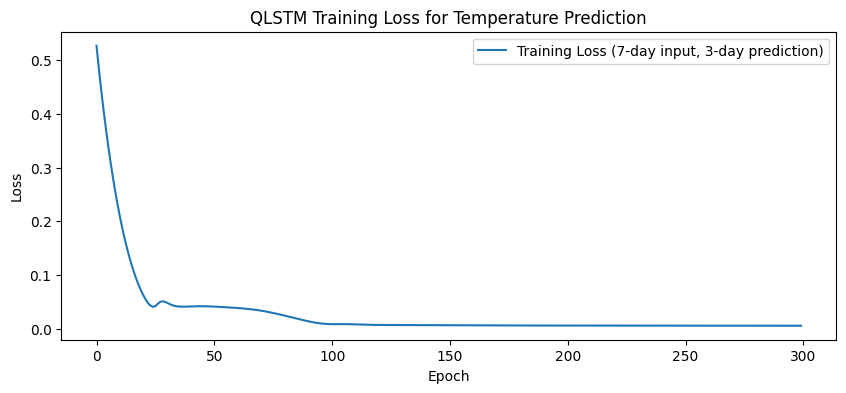

X_test_7_3 len: 1080
y_test_7_3 len: 1080
y_pred_3_days len: 1080
y_test_original_7_3 len: 1080
y_pred_original_3_days len: 1080


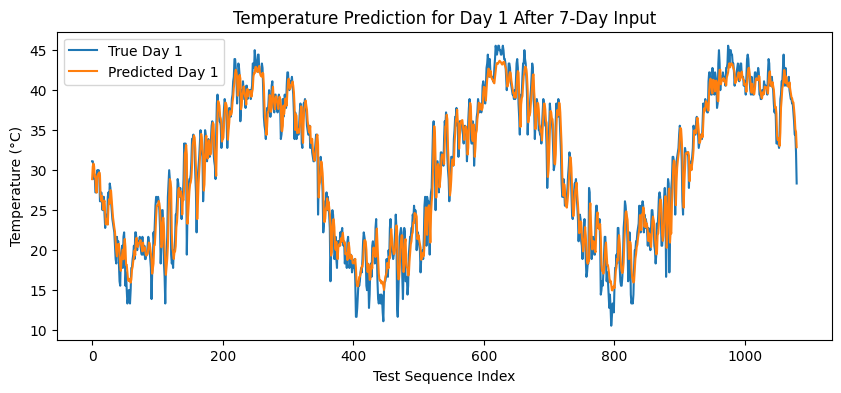

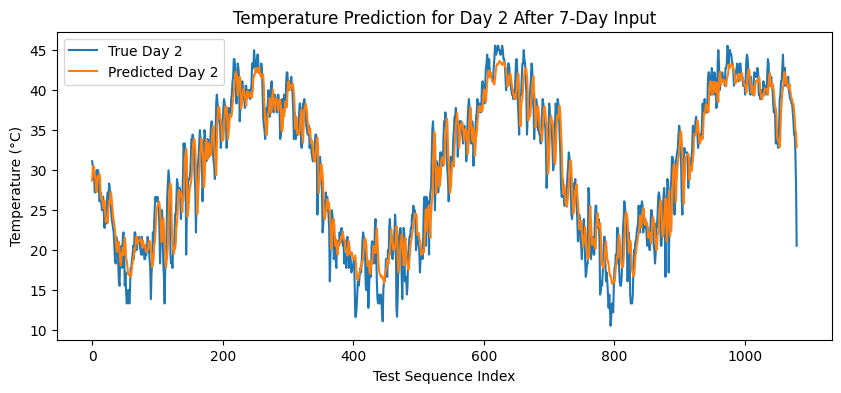

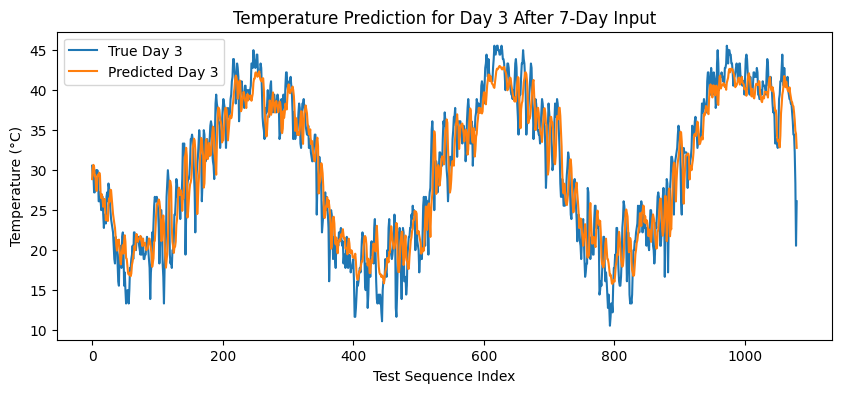

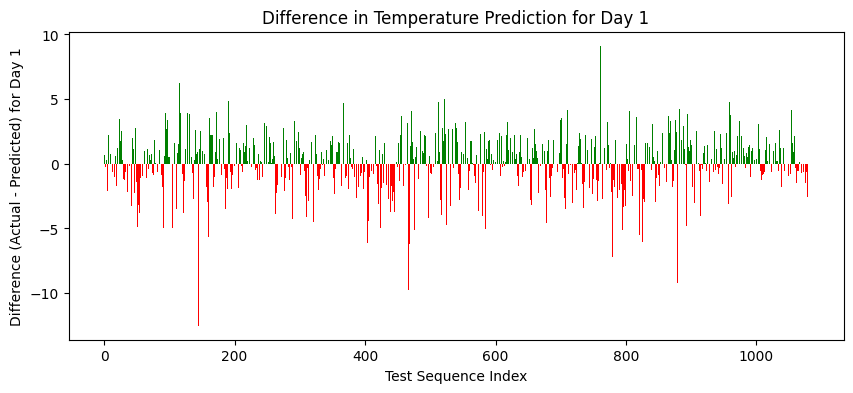

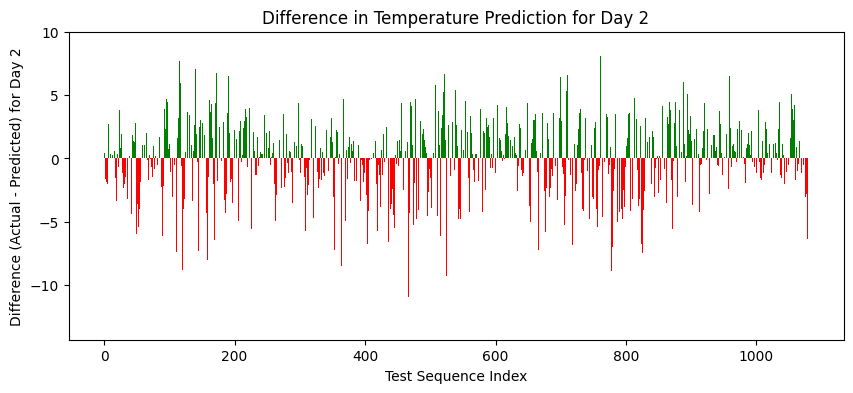

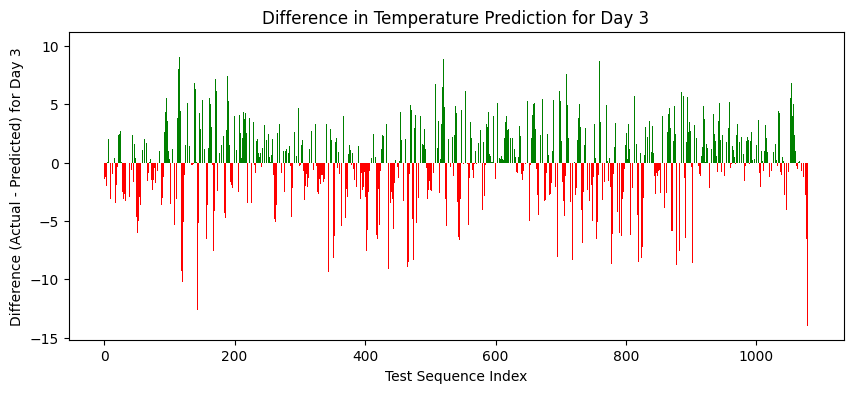


Metrics for Day 1 Prediction:
R² Score: 0.9410
Mean Squared Error (MSE): 4.9289
Mean Absolute Error (MAE): 1.6754
Root Mean Squared Error (RMSE): 2.2201

Metrics for Day 2 Prediction:
R² Score: 0.8880
Mean Squared Error (MSE): 9.3762
Mean Absolute Error (MAE): 2.3808
Root Mean Squared Error (RMSE): 3.0621

Metrics for Day 3 Prediction:
R² Score: 0.8518
Mean Squared Error (MSE): 12.4043
Mean Absolute Error (MAE): 2.7580
Root Mean Squared Error (RMSE): 3.5220


In [23]:
data = daily_max_temp['temp_c'].values.reshape(-1, 1)

# Normalize the data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

data_normalized, scaler = normalize_data(data)

# Sequence creation for 7-day input and 3-day output
def create_sequences_7_3(data, input_seq_length=7, output_seq_length=3):
    sequences, labels = [], []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        seq = data[i:i + input_seq_length]
        label = data[i + input_seq_length:i + input_seq_length + output_seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Initialize variables
input_seq_length = 7
output_seq_length = 3

# Create sequences
X_7_3, y_7_3 = create_sequences_7_3(data_normalized, input_seq_length, output_seq_length)
print(f"Number of sequences: {len(X_7_3)}")  # Should be 1 for 10 values

# For small dataset, use all for training (or adjust for larger dataset)
train_size_7_3 = int(len(X_7_3) * 0.8) or 1  # Ensure at least 1 sequence
X_train_7_3, X_test_7_3 = X_7_3[:train_size_7_3], X_7_3[train_size_7_3:]
y_train_7_3, y_test_7_3 = y_7_3[:train_size_7_3], y_7_3[train_size_7_3:]
print(f"X_train_7_3 shape: {X_train_7_3.shape}, X_test_7_3 shape: {X_test_7_3.shape}")
print(f"y_train_7_3 shape: {y_train_7_3.shape}, y_test_7_3 shape: {y_test_7_3.shape}")

# Convert to tensors
X_train_tensor_7_3 = torch.tensor(X_train_7_3, dtype=torch.float32)
y_train_tensor_7_3 = torch.tensor(y_train_7_3, dtype=torch.float32).squeeze(-1)  # Shape: (n, 3)
X_test_tensor_7_3 = torch.tensor(X_test_7_3, dtype=torch.float32)
y_test_tensor_7_3 = torch.tensor(y_test_7_3, dtype=torch.float32).squeeze(-1)  # Shape: (m, 3)

# Updated LSTMRegressor for 3-day prediction
class LSTMRegressor_7_3(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor_7_3, self).__init__()
        self.hidden_dim = hidden_dim
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM_7_3(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # Output 3 values for 3-day prediction

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
        output = self.fc(lstm_out[:, -1])  # Predict 3 days from last hidden state
        return output

# Model parameters
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 3
backend = 'default.qubit'
model_7_3 = LSTMRegressor_7_3(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model_7_3.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history_7_3 = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs_7_3 = model_7_3(X_train_tensor_7_3)  # Shape: (train_size, 3)
    loss = loss_function(outputs_7_3, y_train_tensor_7_3)
    loss.backward()
    optimizer.step()
    loss_history_7_3.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(loss_history_7_3, label='Training Loss (7-day input, 3-day prediction)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('QLSTM Training Loss for Temperature Prediction')
plt.legend()
plt.show()

# Predict and visualize
model_7_3.eval()
with torch.no_grad():
    y_pred_3_days = model_7_3(X_test_tensor_7_3).detach().numpy()  # Shape: (test_size, 3)

print(f"X_test_7_3 len: {len(X_test_tensor_7_3)}")
print(f"y_test_7_3 len: {len(y_test_7_3)}")
print(f"y_pred_3_days len: {len(y_pred_3_days)}")

# Apply inverse scaling
y_test_original_7_3 = scaler.inverse_transform(y_test_7_3.reshape(-1, 1)).reshape(len(y_test_7_3), 3)
y_pred_original_3_days = scaler.inverse_transform(y_pred_3_days.reshape(-1, 1)).reshape(len(y_pred_3_days), 3)

print(f"y_test_original_7_3 len: {len(y_test_original_7_3)}")
print(f"y_pred_original_3_days len: {len(y_pred_original_3_days)}")

# Plot actual vs predicted for each day
for day in range(3):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_original_7_3[:, day], label=f'True Day {day+1}')
    plt.plot(y_pred_original_3_days[:, day], label=f'Predicted Day {day+1}')
    plt.xlabel('Test Sequence Index')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Prediction for Day {day+1} After 7-Day Input')
    plt.legend()
    plt.show()

# Calculate differences and plot
diff_3_days = y_test_original_7_3 - y_pred_original_3_days
for day in range(3):
    plt.figure(figsize=(10, 4))
    colors = np.where(diff_3_days[:, day] >= 0, 'green', 'red')
    for i in range(len(diff_3_days)):
        plt.bar(i, diff_3_days[i, day], color=colors[i])
    plt.xlabel('Test Sequence Index')
    plt.ylabel(f'Difference (Actual - Predicted) for Day {day+1}')
    plt.title(f'Difference in Temperature Prediction for Day {day+1}')
    plt.show()

# Calculate metrics for each day
for day in range(3):
    r2 = r2_score(y_test_original_7_3[:, day], y_pred_original_3_days[:, day])
    mse = mean_squared_error(y_test_original_7_3[:, day], y_pred_original_3_days[:, day])
    mae = mean_absolute_error(y_test_original_7_3[:, day], y_pred_original_3_days[:, day])
    rmse = np.sqrt(mse)
    print(f"\nMetrics for Day {day+1} Prediction:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# all data prediction seq 3 predict 1 all featuers

In [6]:
data = daily_max_temp.iloc[:, :8].values  # Extract first 8 columns as features
data

array([[  14.        ,   12.74      ,  184.99445061, ..., 1019.7       ,
          10.        ,   19.44444444],
       [  26.        ,   19.77      ,  310.        , ..., 1015.7       ,
          10.        ,   20.55555556],
       [  23.        ,   16.26      ,    0.        , ..., 1017.3       ,
          10.        ,   21.66666667],
       ...,
       [  47.        ,   28.45      ,  250.        , ..., 1003.7       ,
          10.        ,   28.33333333],
       [  37.        ,   30.84      ,  140.        , ..., 1016.3       ,
          10.        ,   20.55555556],
       [  37.        ,   22.05      ,    0.        , ..., 1018.3       ,
          10.        ,   26.11111111]])

In [7]:
# Index of temp_c column
temp_c_index = daily_max_temp.columns.get_loc('temp_c')

# Normalize and create sequences
scaled_data, scaler = normalize_data(data)

# Define parameters
sequence_length = 3

# Create training data
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4323, 3, 8),data X test shape: (1081, 3, 8)
data y train shape: (4323, 8),data y test shape: (1081, 8)


In [8]:
X_train_tensor[:, :, temp_c_index]

tensor([[-3.7838e-01, -3.2432e-01, -2.7027e-01],
        [-3.2432e-01, -2.7027e-01, -2.4324e-01],
        [-2.7027e-01, -2.4324e-01, -2.7027e-01],
        ...,
        [ 1.3514e-01,  8.1081e-02, -2.2204e-16],
        [ 8.1081e-02, -2.2204e-16,  2.7027e-02],
        [-2.2204e-16,  2.7027e-02,  1.0811e-01]])

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml


class QLSTM(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 n_qubits=4,
                 n_qlayers=1,
                 batch_first=True,
                 return_sequences=False,
                 return_state=False,
                 backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        # Define wire names for devices
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        # Define quantum circuits with IQPEmbedding
        def _circuit_forget(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_forget, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]

        def _circuit_input(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_input, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]

        def _circuit_update(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_update, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]

        def _circuit_output(inputs, weights):
            qml.templates.IQPEmbedding(inputs, wires=self.wires_output, n_repeats=1)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]

        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        if self.batch_first:
            batch_size, seq_length, _ = x.size()
        else:
            seq_length, batch_size, _ = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)
            c_t = torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t)))

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0).transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)


class LSTMRegressor_8_dim_3_seq_zzfeatuermap(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor_8_dim_3_seq_zzfeatuermap, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            self.model, self.optimizer, self.criterion = build_lstm_model(input_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        if hasattr(self, 'model'):
            # Use classical LSTM model
            return self.model(x)
        else:
            # Quantum LSTM
            lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
            output = self.fc(lstm_out[:, -1])  # use only last timestep
            return output




Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 1/100 Train Loss: 0.2257 | Val Loss: 0.2310 Train R²: -0.2913 | Val R²: -0.1674
Epoch 2/100 Train Loss: 0.2060 | Val Loss: 0.2139 Train R²: -0.1787 | Val R²: -0.0808
Epoch 3/100 Train Loss: 0.1897 | Val Loss: 0.1996 Train R²: -0.0856 | Val R²: -0.0088
Epoch 4/100 Train Loss: 0.1765 | Val Loss: 0.1883 Train R²: -0.0101 | Val R²: 0.0483
Epoch 5/100 Train Loss: 0.1665 | Val Loss: 0.1811 Train R²: 0.0472 | Val R²: 0.0848
Epoch 6/100 Train Loss: 0.1606 | Val Loss: 0.1793 Train R²: 0.0809 | Val R²: 0.0942
Epoch 7/100 Train Loss: 0.1599 | Val Loss: 0.1790 Train R²: 0.0851 | Val R²: 0.0956
Epoch 8/100 Train Loss: 0.1607 | Val Loss: 0.1759 Train R²: 0.0806 | Val R²: 0.1113
Epoch 9/100 Train Loss: 0.1587 | Val Loss: 0.1690 Train R²: 0.0918 | Val R²: 0.1459
Epoch 10/100 Train Loss: 0.1530 | Val Loss: 0.1597 Train R²: 0.1245 | Val R²: 0.1928
Epoch 11/100 Train Loss: 0.1447 | Val Loss: 0.1499 Train R²: 

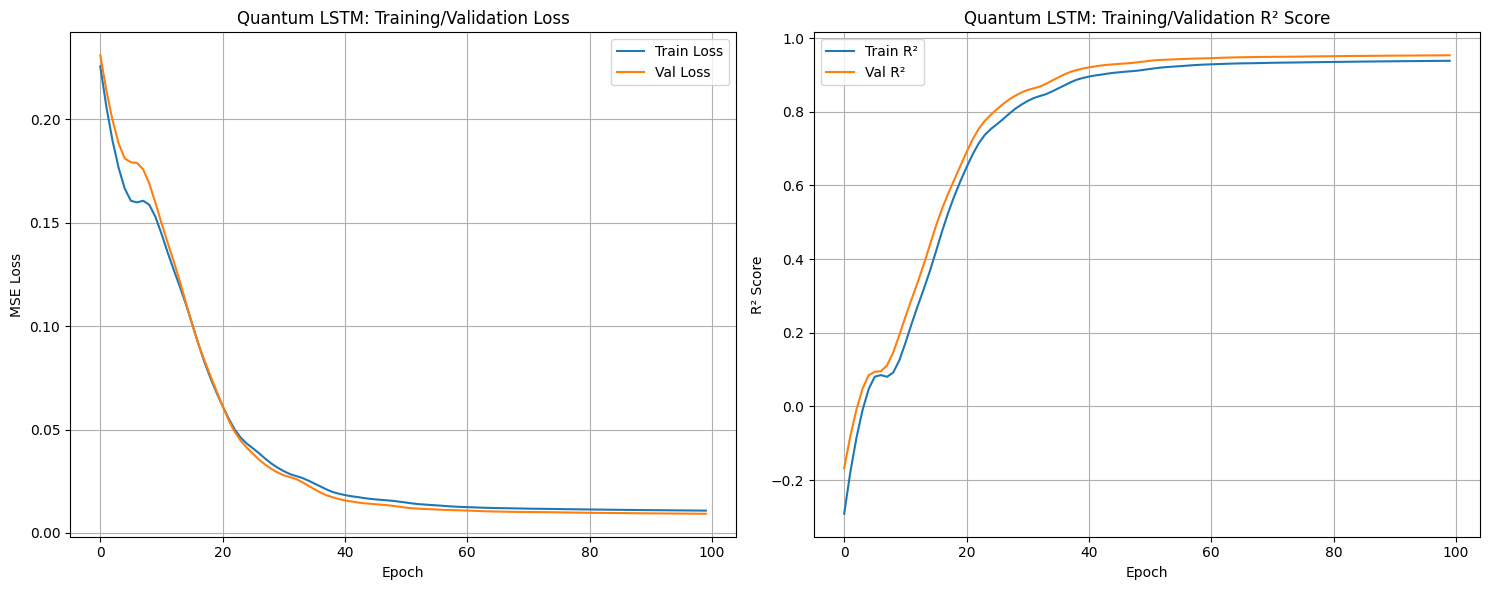

In [14]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'

model = LSTMRegressor_8_dim_3_seq_zzfeatuermap(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 100
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Early stopping setup
best_val_r2 = float('-inf')
patience = 20
patience_counter = 0
best_model_state = None

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs[:, temp_c_index], y_train_tensor[:, temp_c_index])

    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np[:, temp_c_index], train_preds[:, temp_c_index], multioutput='uniform_average')

    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs[:, temp_c_index], y_test_tensor[:, temp_c_index])
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np[:, temp_c_index], val_preds[:, temp_c_index], multioutput='uniform_average')

    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

    # Early stopping logic
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model (optional)
if best_model_state:
    model.load_state_dict(best_model_state)

# Plotting
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Save
torch.save(model.state_dict(), "8_dim_3_seq_1_predict_Qlstm_zzfeatuermap(IQPE)_model_weights.pth")

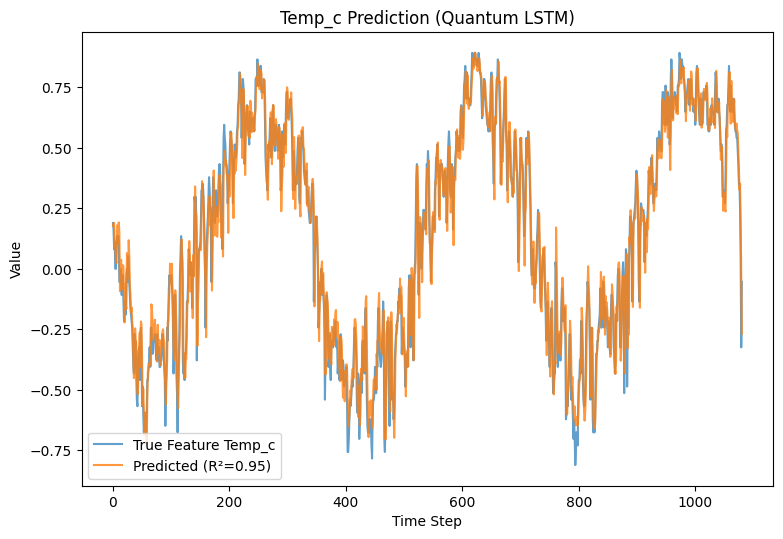


Quantum LSTM - Final Feature-wise Performance:
Feature 8:
  R²   = 0.9533
  MSE  = 3.9014
  MAE  = 1.4642
  RMSE = 1.9752
------------------------------


In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Assuming you used the same scaler for both y_train and y_test
y_8_test_rescaled = scaler.inverse_transform(y_8_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Assuming you have rescaled versions: y_8_test_rescaled and y_pred_rescaled
feature_mse = [mean_squared_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(8)]
feature_mae = [mean_absolute_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(8)]
feature_rmse = [np.sqrt(mean_squared_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i])) for i in range(8)]
# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    if i != temp_c_index:
        continue
    else:
        plt.subplot(4, 2, i+1)
        plt.plot(y_8_test[:, i], label='True Feature Temp_c', alpha=0.7)
        plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
        plt.title(f'Temp_c Prediction (Quantum LSTM)')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
i=7
print(f"Feature {i+1}:")
print(f"  R²   = {feature_r2_scores[i]:.4f}")

print(f"  MSE  = {feature_mse[i]:.4f}")
print(f"  MAE  = {feature_mae[i]:.4f}")
print(f"  RMSE = {feature_rmse[i]:.4f}")
print("-" * 30)

In [17]:
# Function to calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example: Assuming `model` is your PyTorch model
num_parameters = count_parameters(model)

print(f"The model has {num_parameters} trainable parameters.")

The model has 880 trainable parameters.


In [20]:
import numpy as np
import torch

def iterative_forecast_map(model, x_test, days_to_predict, scaler, device="cpu"):
    if isinstance(x_test, torch.Tensor):  # Ensure x_test is a NumPy array
        x_test = x_test.to(device).detach().numpy()

    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = torch.tensor(x_test[i], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dim

            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model(sequence)  # Forward pass instead of predict()
                prediction = prediction.squeeze(0).detach().cpu().numpy()  # Convert back to NumPy
                sequence = np.vstack((sequence.squeeze(0).cpu().numpy()[1:], prediction))  # Update sequence
                sequence = torch.tensor(sequence, dtype=torch.float32, device=device).unsqueeze(0)  # Convert back

            # Final prediction for the current step
            final_prediction = model(sequence).detach().cpu().numpy()
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict

In [21]:
optimize_predictions_10 = iterative_forecast_map(model, X_test_tensor, 4, scaler)
optimize_predictions_10

KeyboardInterrupt: 

prediction num 1

Precision: 0.90
Recall: 0.75
F1 Score: 0.82


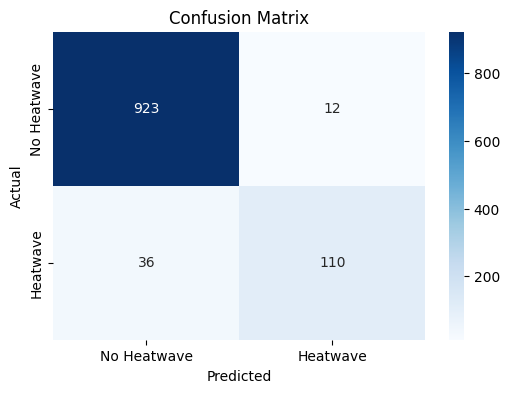

prediction num 2

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


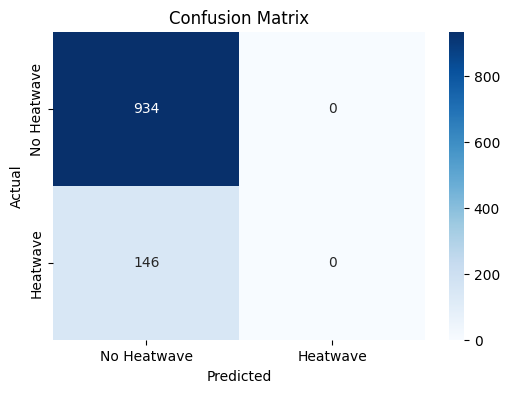

prediction num 3

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


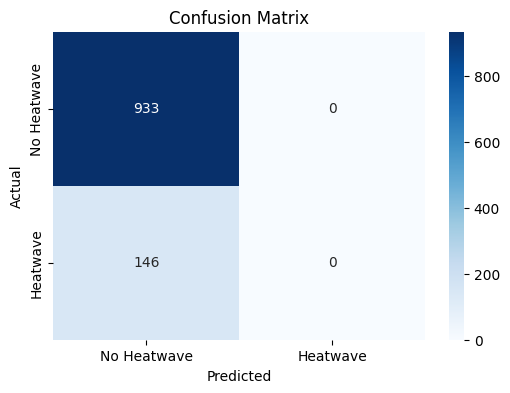

prediction num 4

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


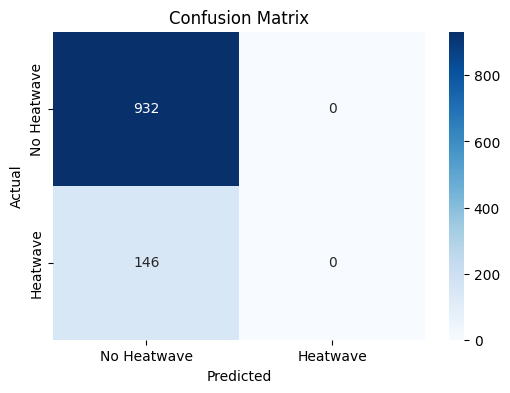

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

threshold = np.percentile(daily_max_temp["temp_c"], 90)

# Function to classify each day based on specified criteria
def classify_heatwave(data, threshold):
    # Convert data to NumPy array if it's a DataFrame or Series
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values
    heatwave = [0] * len(data)  # Initialize the heatwave list with zeros
    for i in range(2, len(data)):
        if data[i] >= threshold:
            if data[i-1] >= threshold and data[i-2] >= threshold:
                heatwave[i] = 1
                heatwave[i-1] = 1
                heatwave[i-2] = 1
            else:
                heatwave[i] = 0
        else:
            heatwave[i] = 0
    return heatwave

# Example actual values (replace with your actual data)
actual_values = pd.DataFrame(y_8_test_rescaled).copy()
predictions=optimize_predictions_10
# Example prediction_dict (replace with your actual prediction_dict)
prediction_dict = optimize_predictions_10

# Initialize lists to store results
all_Precision = []
all_recall = []
all_f1score = []

# Loop through each horizon in prediction_dict
for step in range(1, len(prediction_dict) + 1):
    print(f"prediction num {step}\n")
    
    # Get predictions for the current horizon
    prediction = pd.DataFrame(predictions[step].reshape(len(actual_values) - (step - 1), 8))
    
    # Slice actual values to align with predictions
    temperory_actual_values = actual_values.iloc[step - 1:].copy()
    
    # Classify heatwave for actual values
    actual_heatwave_flags = classify_heatwave(temperory_actual_values[temp_c_index], threshold)
    temperory_actual_values["day_included_heatwave"] = actual_heatwave_flags
    
    # Classify heatwave for predicted values
    prediction_values_heatwave_flags = classify_heatwave(prediction[temp_c_index], threshold)
    prediction["day_included_heatwave"] = prediction_values_heatwave_flags
    
    # Extract heatwave columns
    y_true = temperory_actual_values['day_included_heatwave']
    y_pred = prediction['day_included_heatwave']
    
    # Compute evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Append metrics to lists
    all_Precision.append(precision)
    all_recall.append(recall)
    all_f1score.append(f1)
    
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heatwave', 'Heatwave'], yticklabels=['No Heatwave', 'Heatwave'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

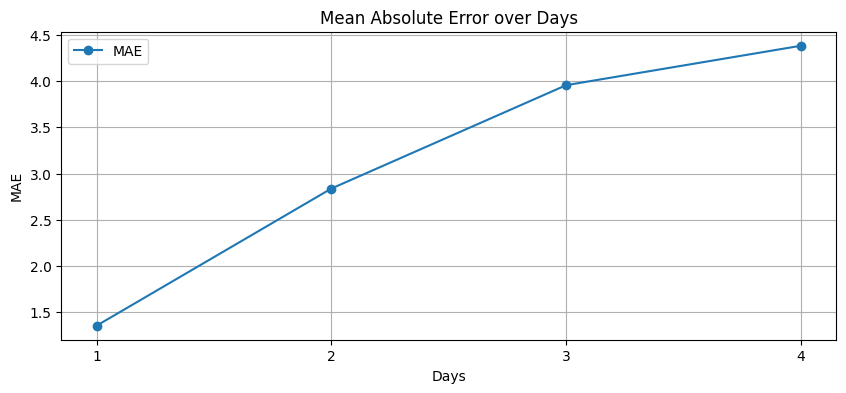

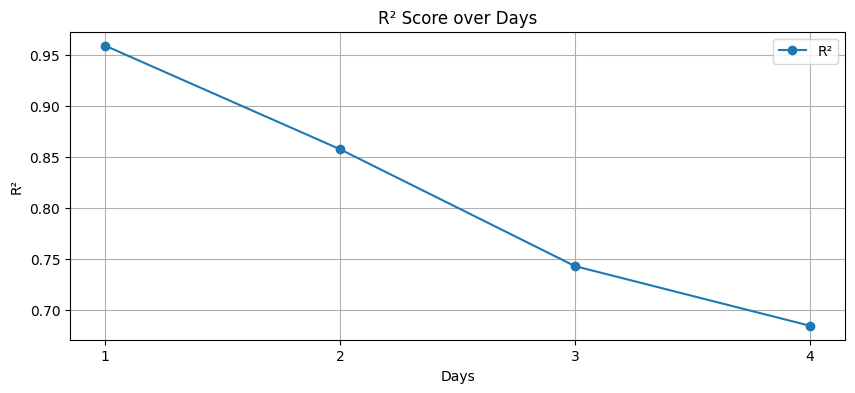

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

prediction_dict = predictions
actual_values = pd.DataFrame(y_8_test_rescaled).copy()

# Initialize lists to store metrics
all_mae = []
all_r2 = []

# Loop through each horizon in prediction_dict
for step in range(1, len(prediction_dict) + 1):    
    # Get predictions for the current horizon
    prediction = pd.DataFrame(predictions[step].reshape(len(actual_values) - (step - 1), 8))
    
    # Slice actual values to align with predictions
    temperory_actual_values = actual_values.iloc[step - 1:].copy()
    
    # Extract actual and predicted temperature values
    y_true = temperory_actual_values[temp_c_index]
    y_pred = prediction[temp_c_index]
    
    # Compute evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Append metrics to lists
    all_mae.append(mae)
    all_r2.append(r2)
    

# Plot MAE over days
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(all_mae) + 1), all_mae, label='MAE', marker='o')
plt.xlabel("Days")
plt.ylabel("MAE")
plt.title("Mean Absolute Error over Days")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(all_mae) + 1))  # Set x-axis ticks to be integer days
plt.show()

# Plot R² over days
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(all_r2) + 1), all_r2, label='R²', marker='o')
plt.xlabel("Days")
plt.ylabel("R²")
plt.title("R² Score over Days")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(all_r2) + 1))  # Set x-axis ticks to be integer days
plt.show()
